In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from util import *
import re
import clip
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [3]:
example_data = np.load("./dataset/sketchrnn_angel.full.npz", encoding='latin1', allow_pickle=True)

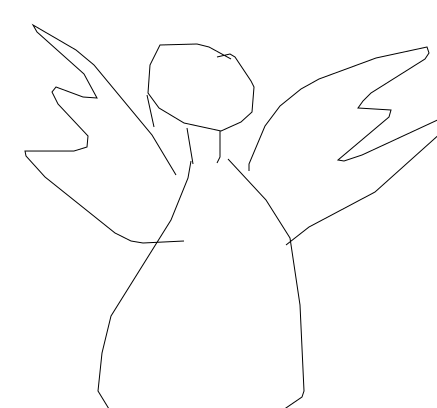

In [4]:
draw_strokes(example_data['train'][100], factor=1)

In [5]:
def encode_stroke_data(stroke_data: np.array):
    # Going from [x, y, lift_pen] to [delta_x, delta_y, pen_on_paper, pen_off_paper, finished]
    new_doodle = np.zeros((stroke_data.shape[0], 5))
    
    # Handling delta_x, delta_y
    new_row = np.zeros((1, 3))
    temp = np.vstack([new_row, stroke_data])
    new_doodle[:, :2] = temp[1:, :2] - temp[:-1, :2]
    
    # Handling pen_on_paper and pen_off_paper
    new_doodle[:, 2] = stroke_data[:, 2] == 0
    new_doodle[:, 3] = stroke_data[:, 2] == 1

    # Handling finished
    new_doodle[-1, 2] = 0 
    new_doodle[-1, 3] = 0 
    new_doodle[-1, 4] = 1

    return new_doodle

def decode_stroke_data(stroke_data: np.array):
    # Going from [delta_x, delta_y, pen_on_paper, pen_off_paper, finished] to [x, y, lift_pen]
    new_doodle = np.zeros((stroke_data.shape[0], 3))
    new_doodle[:, :2] = np.cumsum(stroke_data[:, :2], axis=0)    
    new_doodle[:, 2] = np.logical_or(stroke_data[:, 3], stroke_data[:, 4])
    return new_doodle

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _ = clip.load("ViT-B/32", device=device)

In [6]:
class DoodleDataset(Dataset):
    def __init__(self, data_dir: Path, split: str):
        self.data_dir = data_dir
        self.data = {}
        self.class_embeddings = {}
        
        print("Preprocessing Data:")
        for filepath in tqdm(self.data_dir.glob("*.npz")):
            class_name = self._extract_class_name(filepath)
            class_data = self._extract_data(filepath, split)
            self.data[class_name] = class_data
        
        print("Calculating CLIP Embeddings")
        class_names = list(self.data.keys())
        tokenized_classnames = self.model.tokenize(class_names)
        with torch.no_grad():
            text_features = self.model.encode_text(tokenized_classnames)
        
        for class_name, class_features in zip(class_names, text_features):
            self.class_embeddings[class_name] = class_features

        # Fancy preprocessing for faster indexing        
        self.class_order_counts = [(class_name, len(class_data)) for class_name, class_data in self.data.items()]
        self.class_order_count_cumsum = [0]
        for _, class_count in self.class_order_counts:
            self.class_order_count_cumsum.append(self.class_order_count_cumsum[-1] + class_count)

    def __len__(self):
        return sum(len(class_data) for _, class_data in self.data.items())

    def __getitem__(self, idx):
        assert idx < self.class_order_count_cumsum[-1], f"Index of {idx} is out of bounds, dataset has size {self.__len__()}"
        # [1, 2, 4, 3]
        # [0, 1, 3, 7, 10]
        class_idx = 0
        while idx > self.class_order_count_cumsum[class_idx]:
            class_idx += 1
        
        class_name = self.class_order_counts[class_idx][0]
        in_class_idx = idx - self.class_order_count_cumsum[class_idx]
        return (self.data[class_name][in_class_idx], self.class_embeddings[class_name])
    
    def get_class_name_embedding(self, class_name: str):
        text_tokens = self.tokenizer(class_name)

        with torch.no_grad():
            text_embedding = self.model.encode_text(text_tokens)
        
        # Normalize
        text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
        return text_embedding

    def _extract_class_name(self, file: Path):
        # Example filename: `sketchrnn_apple.full.npz`
        pattern = r"sketchrnn_([^.]+)\.full\.npz"
        match = re.match(pattern, file.name)
        assert match, f"Regex for detecting classname failed on {file}"        
        return match.group(1)

    def _extract_data(self, file: Path, split: str):
        assert split in ["train", "test", "valid"], f"Split {split} is not one of: train, test, valid!"

        raw_data = np.load(file, encoding='latin1', allow_pickle=True)[split]
        encoded_doodles = []
        for doodle in raw_data:
            encoded_doodles.append(encode_stroke_data(doodle))
        
        return encoded_doodles
    

train_dataset = DoodleDataset(Path("./dataset"), split="train")
# train_dataloader = DataLoader(train_dataset, batch_size=256)

# test_dataset = DoodleDataset(Path("./dataset"), split="test")
# test_dataloader = DataLoader(test_dataset, batch_size=256)

Loading CLIP Model


In [ ]:
import torch.nn as nn

class StrokeEncoderMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256)
        )

    def forward(self, x):
        return self.net(x)



In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/hk/38612x253n1dsh0hrzz8lk9c0000gn/T/pip-req-build-bv07d7kh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/hk/38612x253n1dsh0hrzz8lk9c0000gn/T/pip-req-build-bv07d7kh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369488 sha256=8ca48087ac1dc1b4b8314cab04ff648ad1af0056d5c768b2516c83e031f542de
  Stored in directory: /private/var/folders/hk/38612x253n1dsh0hrzz8lk9c0000gn/T/pip-ephem-wheel-cache-jze_dp6l/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [3]:
import torch



text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)
    
print(text_features)

100%|███████████████████████████████████████| 338M/338M [00:43<00:00, 8.16MiB/s]


tensor([[ 0.0547, -0.0061,  0.0495,  ..., -0.6638, -0.1281, -0.4950],
        [ 0.1447,  0.0225, -0.2909,  ..., -0.4472, -0.3420,  0.1798],
        [ 0.1981, -0.2040, -0.1533,  ..., -0.4514, -0.5664,  0.0596]])
